# Synthetic data test: Try different structural indices

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

In [2]:
region = [0, 35e3, 0, 25e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=800)
inclination, declination = 35, -5
base_level = 100
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

## Cube

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


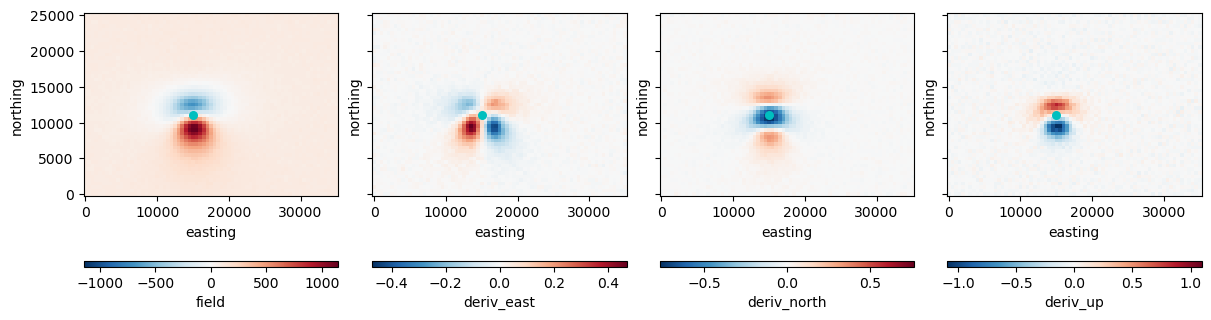

In [3]:
true_coordinates = (15e3, 11e3, -2e3)
size = 1.5e3
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - size, 
        true_coordinates[0] + size, 
        true_coordinates[1] - size, 
        true_coordinates[1] + size, 
        true_coordinates[2] - size, 
        true_coordinates[2] + size, 
    ],
    magnetization=hm.magnetic_angles_to_vec(10, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, 5, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained', sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
plt.show()

In [4]:
prism = {}
for si in [1, 2, 3]:    
    prism[si] = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={prism[si].data_misfit_[-1]} | Position={prism[si].source_location_}")

SI=1 | RMSE=1.3620156659052125 | Position=[15546.37931908 11314.24371969  -383.53535461]
SI=2 | RMSE=0.6375790846688387 | Position=[15002.01021279 11057.50654748 -1301.42148591]
SI=3 | RMSE=0.42014934522100733 | Position=[14991.80292337 11002.63478207 -2333.62092255]


## Pipe

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


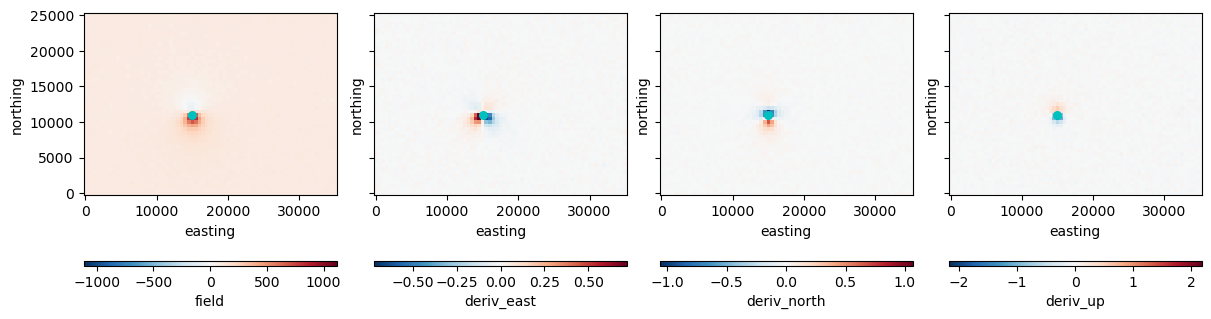

In [5]:
true_coordinates = (15e3, 11e3, 0e3)
size = 50
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - size, 
        true_coordinates[0] + size, 
        true_coordinates[1] - size, 
        true_coordinates[1] + size, 
        true_coordinates[2] - 15e3, 
        true_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(1000, 90, 0),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, 5, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained', sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
plt.show()

In [6]:
pipe = {}
for si in [1, 2, 3]:    
    pipe[si] = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={pipe[si].data_misfit_[-1]} | Position={pipe[si].source_location_}")

SI=1 | RMSE=0.709957197254224 | Position=[14995.10983358 11107.30729778   353.55331516]
SI=2 | RMSE=0.4155805855323469 | Position=[15000.72278601 11014.87242173  -102.90121908]
SI=3 | RMSE=0.471520996636389 | Position=[15001.00272722 11004.32509508  -676.1356532 ]


## Dike

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


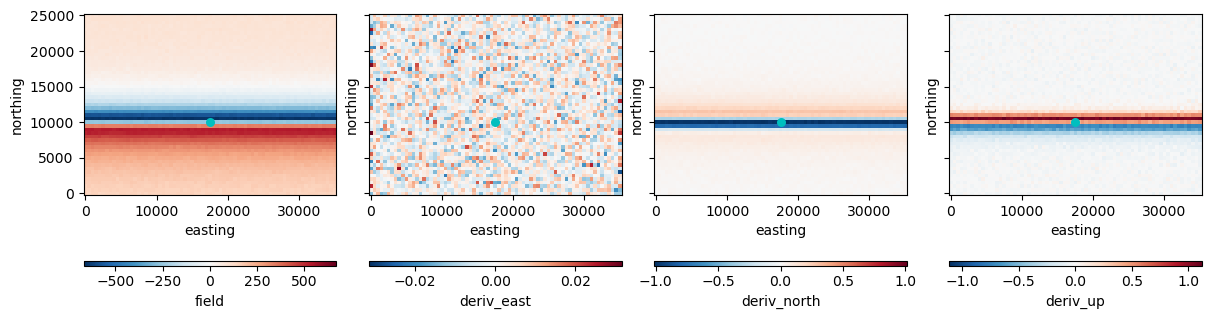

In [7]:
true_coordinates = (17.5e3, 10e3, 0e3)
size = 50e3
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - size, 
        true_coordinates[0] + size, 
        true_coordinates[1] - 250, 
        true_coordinates[1] + 250, 
        true_coordinates[2] - 7e3, 
        true_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(10, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, 5, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained', sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
plt.show()

In [8]:
dike = {}
for si in [1, 2, 3]:    
    dike[si] = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={dike[si].data_misfit_[-1]} | Position={dike[si].source_location_}")

SI=1 | RMSE=0.13585133134212068 | Position=[16028.84969978 10003.39029677   -73.96858274]
SI=2 | RMSE=0.17943257847868874 | Position=[15198.13983427  9999.10914455  -886.25552816]
SI=3 | RMSE=0.2280828669551907 | Position=[12771.14065522  9997.11595977 -1866.90697783]


## Sill

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


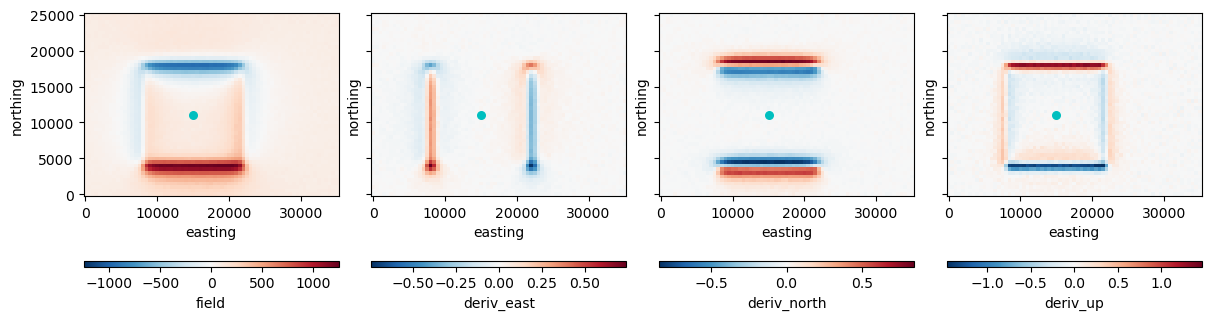

In [9]:
true_coordinates = (15e3, 11e3, 0e3)
size = 7e3
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - size, 
        true_coordinates[0] + size, 
        true_coordinates[1] - size, 
        true_coordinates[1] + size, 
        true_coordinates[2] - 100, 
        true_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(50, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, 5, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained', sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
plt.show()

In [10]:
sill = {}
for si in [1, 2, 3]:    
    sill[si] = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={sill[si].data_misfit_[-1]} | Position={sill[si].source_location_}")

SI=1 | RMSE=4.875779217628729 | Position=[21809.63250752 20166.50091961   -72.6591385 ]
SI=2 | RMSE=5.014988677688063 | Position=[21384.41614701 19398.5773357   -855.07700699]
SI=3 | RMSE=5.228465829224164 | Position=[21550.70333986 18214.58847874 -1640.45485824]


## Line

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


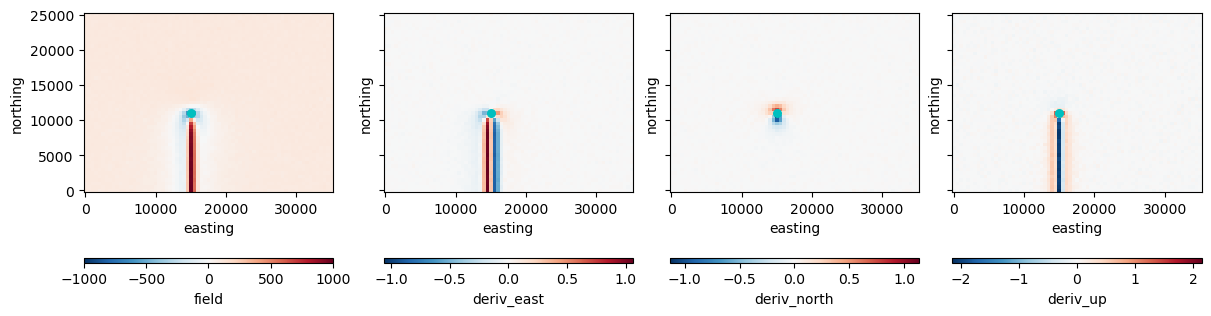

In [13]:
true_coordinates = (15e3, 11e3, 0e3)
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - 50, 
        true_coordinates[0] + 50, 
        true_coordinates[1] - 50e3, 
        true_coordinates[1], 
        true_coordinates[2] - 100, 
        true_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(1000, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, 5, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained', sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
plt.show()

In [14]:
line = {}
for si in [1, 2, 3]:    
    line[si] = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={line[si].data_misfit_[-1]} | Position={line[si].source_location_}")

SI=1 | RMSE=0.4948645798383384 | Position=[15003.32915217 10974.40769921   272.21750075]
SI=2 | RMSE=0.32506300611971345 | Position=[14997.20106129 10977.80262263  -127.98195537]
SI=3 | RMSE=0.44995205054018733 | Position=[14999.48668623 11018.09253705  -579.209688  ]
